# Ансамбли. Бустинг.

## ЗАДАНИЕ I. ДОПОЛНИТЕЛЬНОЕ

**Дано**: набор данных из системы поискового антиспама.

**Требуется**: сравнить классификаторы, основанные на алгоритмических композициях, с классическими алгоритмами классификации (SVM, логистическая регрессия) и нейросетями (двуслойный персептрон).

1. Скачать данные и запустить шаблон кода на python:
```
$ python compos.py -h
$ python compos.py -tr spam.train.txt -te spam.test.txt
```
2. Подобрать параметры трёх алгоритмических композиций (RF, Adaboost, GBM), чтобы они превосходили по качеству SVM, логистическую регрессию и двуслойный персептрон.

3. Построить графики качества классификации в зависимости от числа базовых моделей.

4*. Построить графики качества классификации в зависимости от параметров алгоритмов (XGBoost, dart, LightGBM и CatBoost)

### **1.** Пример работы шаблона кода. Качество на SVM, логистической регрессии и двуслойном перцептроне.

In [10]:
!python compos.py -h

usage: compos.py [-h] [-tr TRAIN] [-te TEST] [-t TREES] [-fp FEATURES_PERCENT]

Random Forest Tutorial

optional arguments:
  -h, --help            show this help message and exit
  -tr TRAIN, --train TRAIN
                        Train file name
  -te TEST, --test TEST
                        Test file name
  -t TREES, --trees TREES
                        Number of trees in random forest
  -fp FEATURES_PERCENT, --features_percent FEATURES_PERCENT
                        Percent of features in each tree


In [11]:
!python compos.py -tr spam.train.txt -te spam.test.txt

Build random forest classifier...
Build adaboost classifier...
Build gbm classifier...
Build svm classifier...
Random Forest :
             precision    recall  f1-score   support

        0.0    0.54760   0.87998   0.67509      2033
        1.0    0.96406   0.81578   0.88374      8023

avg / total    0.87986   0.82876   0.84156     10056
final score    0.75583   0.84788   0.77942     10056

AdaBoost :
             precision    recall  f1-score   support

        0.0    0.92398   0.42450   0.58173      2033
        1.0    0.87174   0.99115   0.92762      8023

avg / total    0.88230   0.87659   0.85769     10056
final score    0.89786   0.70782   0.75467     10056

Gradient Boosting Machine :
             precision    recall  f1-score   support

        0.0    0.67793   0.84899   0.75388      2033
        1.0    0.95912   0.89779   0.92744      8023

avg / total    0.90227   0.88793   0.89235     10056
final score    0.81852   0.87339   0.84066     10056

SVM :
             precision  

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import svm

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from sklearn.metrics import f1_score
#from sklearn.utils.multiclass import unique_labels
#from sklearn.decomposition import PCA


from compos import visualize_data, classification_report


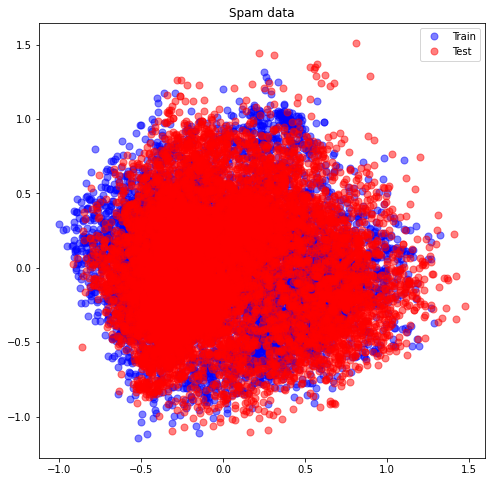

In [2]:
train_data = np.loadtxt("spam.train.txt")
test_data  = np.loadtxt("spam.test.txt")

total_data = np.concatenate(([train_data, test_data]), axis=0)

X_train, y_train = train_data[:, 1:], train_data[:, 0]
X_test, y_test = test_data[:, 1:], test_data[:, 0]

visualize_data(total_data[0::, 1::], len(train_data[:,0]), len(test_data[:,0]))

#number_of_features = len(train_data[0, 1:])

In [28]:
X_train.shape, X_test.shape

((7093, 102), (10056, 102))

In [32]:
number_of_features

102

**Логистическая регрессия (параметры были подобраны в предыдущем дз)**

In [61]:
log_reg = LogisticRegression(random_state=0, C=1.0, l1_ratio=None, penalty='l1',solver='liblinear')
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Logistic regression"))

f1-score=0.9360198874787389
Logistic regression :
             precision    recall  f1-score   support

        0.0    0.68887   0.94638   0.79735      2033
        1.0    0.98499   0.89169   0.93602      8023

avg / total    0.92512   0.90274   0.90798     10056
final score    0.83693   0.91904   0.86668     10056



**SVM**

In [62]:
svm_clf = svm.SVC(kernel="rbf")
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="SVM with rbf kernel"))

f1-score=0.9585241566148487
SVM with rbf kernel :
             precision    recall  f1-score   support

        0.0    0.76980   0.97541   0.86049      2033
        1.0    0.99332   0.92609   0.95852      8023

avg / total    0.94813   0.93606   0.93870     10056
final score    0.88156   0.95075   0.90951     10056



**Двуслойный перцептрон**

In [68]:
import torch
from torch.nn import MSELoss, Linear, Sigmoid, Sequential

NN = Sequential(Linear(102, 100), Sigmoid(), Linear(100, 1))

In [69]:
def train(network, X_train, y_train, n_epoch, lrate):
    losses = []
    loss = MSELoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=lrate)
    for _ in tqdm(range(n_epoch)):
        optimizer.zero_grad()
        out = network(X_train)
        l = loss(out, y_train)
        losses.append(l.detach().numpy())
        l.backward()
        optimizer.step()
    return losses

In [70]:
losses = train(NN, torch.from_numpy(X_train).float(), torch.from_numpy(y_train[:,np.newaxis]).float(), 400, 0.001)
y_pred = NN(torch.from_numpy(X_test).float())
print("f1-score={}".format(f1_score(y_test, (y_pred.detach().numpy() > 0.5).astype(int))))
print(classification_report(y_test, (y_pred.detach().numpy() > 0.5).astype(int), alg_name="Perceptron"))

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 178.17it/s]

f1-score=0.9389823900188446
Perceptron :
             precision    recall  f1-score   support

        0.0    0.70335   0.93064   0.80119      2033
        1.0    0.98086   0.90054   0.93898      8023

avg / total    0.92475   0.90662   0.91112     10056
final score    0.84210   0.91559   0.87008     10056



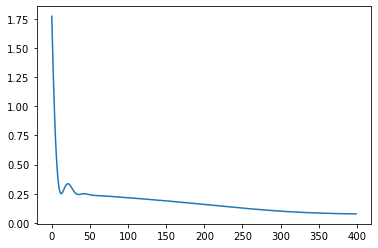

In [71]:
import matplotlib.pyplot as plt
plt.plot(losses)

### **2. и 3.** Подброр параметров для RF, Adaboost, GBM. Графики зависимости качества от числа базовых алгоритмов.

In [6]:
from sklearn.model_selection import GridSearchCV

def find_best_param(params_dict, clf, X, y):

    search = GridSearchCV(clf, param_grid=params, cv=3, n_jobs=-1)
    search.fit(X, y)
    
    return search.best_estimator_

**Random Forest**

In [47]:
params = {
        'n_estimators': range(100, 1051, 50),
        'max_features': np.linspace(0.3, 1.0, 3)
    }
RF_best = find_best_param(params, RandomForestClassifier(), X_train, y_train)

In [48]:
RF_best

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [75]:
y_pred = RF_best.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Random Forest"))

f1-score=0.9648922686945501
Random Forest :
             precision    recall  f1-score   support

        0.0    0.82166   0.92917   0.87211      2033
        1.0    0.98144   0.94890   0.96489      8023

avg / total    0.94913   0.94491   0.94614     10056
final score    0.90155   0.93903   0.91850     10056



In [82]:
def best_num_estim(clf, X_train, y_train, X_test, y_test, min_est, max_est, step):
    num_est = list(range(min_est, max_est, step))
    f1_scores = []
    best_score = 0
    best_n_est = 0
    best_clf = None
    for i in tqdm(range(min_est, max_est, step)):
        clf = clf.set_params(**{'n_estimators': i})
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred)
        if best_score < score:
            best_score = score
            best_n_est = i
            best_clf = clf
        f1_scores.append(score)
    plt.plot(num_est, f1_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('f1-score')
    plt.title("Tuning of n_estimators parameter")
    return best_clf, f1_scores, best_n_est, best_score

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [12:59<00:00, 33.89s/it]


150

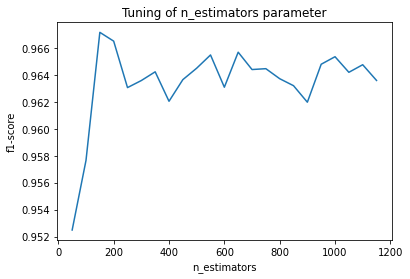

In [93]:
import matplotlib.pyplot as plt
best_RF, f1_scores, best_n_est, best_score = best_num_estim(RandomForestClassifier(max_features=0.3), X_train, y_train, X_test, y_test, 50, 1151, 50)
best_n_est

In [92]:
print("N-estimators={}".format(best_n_est))

N-estimators=250


In [91]:
y_pred = best_RF.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Random Forest"))

f1-score=0.9656698488967568
Random Forest :
             precision    recall  f1-score   support

        0.0    0.82935   0.92277   0.87357      2033
        1.0    0.97986   0.95189   0.96567      8023

avg / total    0.94943   0.94600   0.94705     10056
final score    0.90461   0.93733   0.91962     10056



**Adaboost**

In [79]:
params = {
        'n_estimators': range(50, 601, 50),
        'learning_rate': np.logspace(-2, 0, 3)
    }
ada_best = find_best_param(params, AdaBoostClassifier(), X_train, y_train)

In [80]:
ada_best

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.1,
                   n_estimators=600, random_state=None)

In [81]:
y_pred = ada_best.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Adaboost"))

f1-score=0.9700055204563578
Adaboost :
             precision    recall  f1-score   support

        0.0    0.93468   0.81653   0.87162      2033
        1.0    0.95495   0.98554   0.97001      8023

avg / total    0.95085   0.95137   0.95012     10056
final score    0.94482   0.90103   0.92081     10056



100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [06:05<00:00, 17.41s/it]


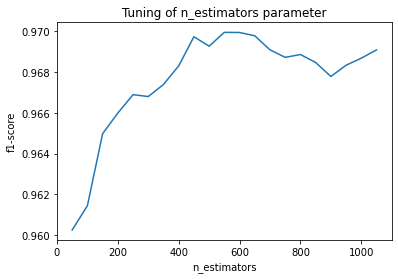

In [83]:
best_ada, f1_scores, best_n_est, best_score = best_num_estim(AdaBoostClassifier(learning_rate=0.1), X_train, y_train, X_test, y_test, 50, 1051, 50)

In [87]:
print("N-estimators={}".format(best_n_est))

N-estimators=550


In [86]:
y_pred = best_ada.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="Adaboost"))

f1-score=0.9690900098911969
Adaboost :
             precision    recall  f1-score   support

        0.0    0.90279   0.84506   0.87297      2033
        1.0    0.96136   0.97694   0.96909      8023

avg / total    0.94952   0.95028   0.94966     10056
final score    0.93207   0.91100   0.92103     10056



**GBM**

100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [12:26<00:00, 35.53s/it]


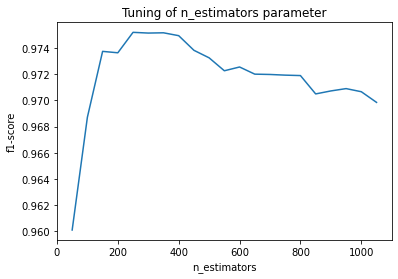

In [94]:
best_gbm, f1_scores, best_n_est, best_score = best_num_estim(GradientBoostingClassifier(), X_train, y_train, X_test, y_test, 50, 1051, 50)

In [95]:
print("N-estimators={}".format(best_n_est))

N-estimators=250


In [96]:
y_pred = best_gbm.predict(X_test)
print("f1-score={}".format(f1_score(y_test, y_pred)))
print(classification_report(y_test, y_pred, alg_name="GBM"))

f1-score=0.9698523892919689
GBM :
             precision    recall  f1-score   support

        0.0    0.87088   0.89572   0.88312      2033
        1.0    0.97338   0.96635   0.96985      8023

avg / total    0.95266   0.95207   0.95232     10056
final score    0.92213   0.93103   0.92649     10056



### Сравнение качества разных алгоритмов.

*total f1-score* - это f1-score, подсчитанный на всех данных.

*mean f1-score for classes* - это среднее между f1-score для классов спам и неспам.

| Algorithm | total f1-score | mean f1-score for classes |
| --- | --- | --- |
| Logistic regression | 0.9360 | 0.8666 |
| SVM | 0.9585 | 0.9095|
| Perceptron | 0.9389 | 0.8700 |
| Random forest | 0.9656 | 0.9196 |
| Adaboost | 0.9690 | 0.9210 |
| GBM | 0.9698 | 0.9264 |


### Сравнение xgboost, lightgbm и catboost

In [52]:
import xgboost as xgb
import lightgbm as lgb

ModuleNotFoundError: No module named 'lightgbm'

## ЗАДАНИЕ II. ОСНОВНОЕ

In [134]:
def ComputeMyTaskNumber(your_name):
    return 1 + hash(your_name) % 21
ComputeMyTaskNumber("Vakulenko_Yulia")

4


Моё задание - 4. Реализация алгоритма градиентного бустинга с логистической функцией потерь. В качестве базового алгоритма использовать алгоритм CART (задача классификации).

Модель взвешенного голосования:

$$h(x) = \sum_{i=1}^{T}b_i a_i(x), x\in X, b_i\in R $$

Ошибка композиции на обучающей выборке:

$$error = \sum_{j=1}^{N} L(y_j,\sum_{i=1}^{T-1}b_i a_i(x_j) + b a(x_j))$$

Логистическая функция потерь:

$$L(h) = \sum_{j=1}^{N} (-y_j \log f(x_j) - (1 - y_j)\log (1 - f(x_j)))$$

$$f(x_j) = \sigma (h(x_j)) = \frac{1}{1 + \exp^{-h(x_j)}}$$

Рассчитаем антиградиент лосс-функции. Введем обозначение $h(x_j) = h_j $.

Производная сигмоиды:
$$\sigma(h)^{'} = \sigma(h)(1 - \sigma(h))$$

Градиент:
$$\frac{\partial L(y_j, h(x_j))}{\partial h(x_j)} =  \frac{}{\partial h_j} (\sum_{k=1}^{N}(-y_k \log \sigma(h_k)  - (1 - y_k)\log (1 - \sigma(h_j)))) = \frac{}{\partial h(x_j)} (-y_j \log \sigma(h_j) - (1 - y_j)\log (1 - \sigma(h_j))) =  -y_j \frac{\sigma(h_j)(1 - \sigma(h_j))}{\sigma(h_j)} - (1 - y_j)\frac{-\sigma(h_j)(1-\sigma(h_j))}{1-\sigma(h_j)} = -y_j(1 - \sigma(h_j)) + (1 - y_j)\sigma(h_j) = \sigma(h_j) - y_j$$

Антиградиент функции потерь:
$$ -\frac{\partial L(y_j, h(x_j))}{\partial h(x_j)} = y_j - \sigma(h(x_j))$$

Для нахождения коэффициента $b = argmin_b \sum_{j=1}^{N}L(y_j, h_{i-1}(x)+ b a_i(x))$ воспользуемся методом Ньютона.


$$f' = \frac {\partial L}{\partial b} = \sum_{j=1}^{N} a(x_j) (y_j - \sigma (h_{i-1}(x_j) + b a(x_j)))$$
$$f'' = \frac {\partial^2 L}{\partial b^2} = \sum_{j=1}^{N} a^2(x_j) \sigma(1 - \sigma)$$

$$b_k = b_{k-1} - \frac{f'}{f''}$$


In [28]:
# Classification and regression tree
class CART():
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        # left child
        self.left = None
        # right child
        self.right = None
        # index of feature that is used to divide samples
        self.feature_idx = -1
        self.feature_threshold = 0
        # value in leaf
        self.value = 0
        self.criterion = 'mse'
    
    def __mse(self, y):
        return ((y - y.mean()) ** 2).sum()
    
    def error(self, y):
        if self.criterion == 'mse':
            return self.__mse(y)
        
        
    def fit(self, X, y):
        self.value = y.mean()
        
        #print(self.max_depth, self.value)
        
        #stopping criterion
        if self.max_depth < 1:
            return
        
        n_samples = X.shape[0]
        
        best_impurity = None
        error = self.error(y)

        #finding feature for split
        for f in range(X.shape[1]):
            #print(self.feature_idx, best_impurity)
            # indices of samples sorted by value of feature f
            idxs = np.argsort(X[:, f])
            
            # sum of y_true values in fraction of samples
            sum_left = y.sum()
            sum_right = 0

            # number of samples in left and right subtrees
            N_left, N_right = n_samples, 0
            
            #threshold feature's serial number 
            thres = 0
            
            # finding best value of feature f to split 
            while thres < n_samples - 1:
                N_left -= 1
                N_right += 1
                
                # sample with feature index thres
                idx = idxs[thres]
                
                # value of object with idx index
                x = X[idx, f]
                
                sum_left -= y[idx]
                sum_right += y[idx]
                        
                new_error = -((sum_left - sum_left/N_left)**2)/N_left - ((sum_right - sum_right/N_right)**2)/N_right
                
                # equal values of feature
                if thres < n_samples - 1 and x == X[idxs[thres + 1], f]:
                    thres += 1
                    continue

                if self.feature_idx == -1 or new_error < best_impurity:
                    self.feature_idx = f
                    self.feature_threshold = (X[idx, f] + X[idxs[thres + 1], f])/2
                    best_impurity = new_error
                thres += 1
        if self.feature_idx == -1:
            return
        
        # indices for left and right subsamples
        idxs_l = (X[:, self.feature_idx] > self.feature_threshold)
        idxs_r = (X[:, self.feature_idx] <= self.feature_threshold)
    
        #print("feature index = {}, feature threshold = {}".format(self.feature_idx, self.feature_threshold))
        #print("best impurity = {}".format(best_impurity))
        # recursively finds best splits for left and right subtrees
        self.left = CART(self.max_depth - 1)
        self.left.value = y[idxs_l].mean()
        self.right = CART(self.max_depth - 1)
        self.left.value = y[idxs_r].mean()
        
        
    
        self.left.fit(X[idxs_l, :], y[idxs_l])
        self.right.fit(X[idxs_r, :], y[idxs_r])

        
    def __predict(self, x):
        if self.feature_idx == -1:
            return self.value
        
        if x[self.feature_idx] > self.feature_threshold:
            return self.left.__predict(x)
        else:
            return self.right.__predict(x)
        
    def predict(self, X):
        y = np.zeros(X.shape[0])
        
        for i in range(X.shape[0]):
            y[i] = self.__predict(X[i])
            
        return y


In [31]:
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor(max_depth=1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)

0.12446198984602179

In [32]:
myclf = CART(max_depth=1)
myclf.fit(X_train, y_train)
y_pred2 = myclf.predict(X_test)
mean_squared_error(y_test, y_pred2)

0.12446198984602179

In [34]:
class GBM:
    
    #threshold for classification
    THR = 0.5
    
    def __init__(self, n_estimators=100, learning_rate=0.01, max_depth=3, base_model=CART):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.base_model = base_model
        
        # coefficients for estimators
        self.b = []
        # list with estimators
        self.a = []
        
        self.staged_losses = []

    # logistic fuction
    def __sigmoid(self, h):
        return 1/(1 + np.exp(-h))

    def __negative_grad(self, y, h):
        return  (y - self.__sigmoid(h))
    
    def __log_loss(self, y, y_pred):
        
        sigma = self.__sigmoid(y_pred)
        loss = np.sum(-y*np.log(sigma) - (1 - y)*np.log(1-sigma))
        
        return loss
    
    def calc_b_i(self, h, a, y):
        b = 0
        f1 = 10
        eps = 0.001

        while np.abs(f1) > eps:
            Hba = h + b * a
            sigma = self.__sigmoid(Hba)
            # first derivative
            f1 = np.sum(a*(sigma - y))
            # second derivative
            f2 = np.sum(a*a*sigma*(1-sigma))
            delta = f1/f2
            b = b - delta

        return b
    
    def fit(self, X, y):
        # initial prediction is set to be zeros
        h = np.zeros(y.shape[0])
        
        for i in tqdm(range(self.n_estimators)):
            #print(i)
            # vector with antigradients
            g_i = self.__negative_grad(y, h)
            #print('neg_grad = {}'.format(g_i))
            # i-th estimator
            a_i = self.base_model(max_depth=self.max_depth)
            a_i.fit(X, g_i)
            #prediction of i-th estimator
            a_i_pred = a_i.predict(X)
            #print("y_pred={}".format(h))
            #print("y_pred_new={}".format(a_i_pred))
            
            #coefficient for new estimator
            b_i = self.calc_b_i(h, a_i_pred, y) * self.learning_rate
            #print('b_i={}'.format(b_i))
            self.b.append(b_i)
            self.a.append(a_i)
            
            h = h + b_i * a_i_pred
            
            self.staged_losses.append(self.__log_loss(y, h))
        return self
    
    def predict(self, X):
        y_pred_proba = self.predict_proba(X)
        y_pred = np.where(y_pred_proba < self.__class__.THR, 0, 1)
        return y_pred
    
    def predict_proba(self, X):
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
        return self.__sigmoid(y_pred)
        
    def predict_all_steps(self, X):
        y_preds = [None] * self.n_estimators
        y_pred = np.zeros(X.shape[0])
        for i in range(self.n_estimators):
            y_pred = y_pred + self.b[i] * self.a[i].predict(X)
            y_preds[i] = np.where(self.__sigmoid(y_pred) < self.__class__.THR, 0, 1)
        return y_preds

In [35]:
my_gb = GBM(learning_rate=0.1, n_estimators=150, 
                         base_model=CART, max_depth=1)
my_gb.fit(X_train, y_train)
y_pred_my = my_gb.predict(X_test)
f1_score(y_test, y_pred_my)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [05:17<00:00,  2.12s/it]


0.9684771164922276

In [36]:
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=150, 
                                 max_depth=1, criterion='mse')
clf.fit(X_train, y_train)
y_pred_sk = clf.predict(X_test)
f1_score(y_test, y_pred_sk)

0.9674154529745742

In [37]:
my_pred_train = my_gb.predict_all_steps(X_train)
my_pred_test = my_gb.predict_all_steps(X_test)

In [42]:
def plot_comp_scores(sk_scores, my_scores, title):
    # Plot for comparison of scores from sklearn and mine clfs
    n = len(sk_scores)
    x = np.arange(1,n+1)
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.plot(x, sk_scores, 'm-', label='sklearn test')
    plt.plot(x, my_scores , 'c-', label='my gbm test')
    plt.plot(x, [s * 1.03 for s in sk_scores], 'm-', linestyle='--')
    plt.plot(x, [s * 0.97 for s in sk_scores], 'm-', linestyle='--')
    plt.legend(loc='best')
    plt.xlabel('Iterations')
    plt.ylabel('f1-score')

    print(f"sklearn f1-score = {sk_scores[-1]:.4f}")
    print(f"threshold 3% = {0.97 * sk_scores[-1]:.4f}..{1.03 * sk_scores[-1]:.4f}")
    print(f"my f1-score = {my_scores[-1]:.4f}")

In [46]:
n_est = 150

sk_test_scores = np.zeros(n_est)
sk_train_scores = np.zeros(n_est)

my_test_scores = np.zeros(n_est)
my_train_scores = np.zeros(n_est)



for i, y_pred in enumerate(clf.staged_decision_function(X_train)):
    sk_train_scores[i] = f1_score(y_train, np.where(my_gb._GBM__sigmoid(y_pred) < 0.5, 0, 1))
    
for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
    sk_test_scores[i] = f1_score(y_test, np.where(my_gb._GBM__sigmoid(y_pred) < 0.5, 0, 1))

    

for i, y_pred in enumerate(my_pred_train):
    my_train_scores[i] = f1_score(y_train, y_pred)    
    
for i, y_pred in enumerate(my_pred_test):
    my_test_scores[i] = f1_score(y_test, y_pred)


sklearn f1-score = 0.9598
threshold 3% = 0.9310..0.9886
my f1-score = 0.9615


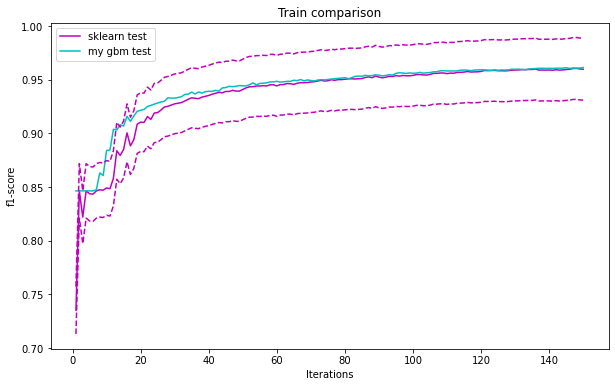

In [50]:
plot_comp_scores(sk_train_scores, my_train_scores, 'Train comparison')

sklearn f1-score = 0.9674
threshold 3% = 0.9384..0.9964
my f1-score = 0.9685


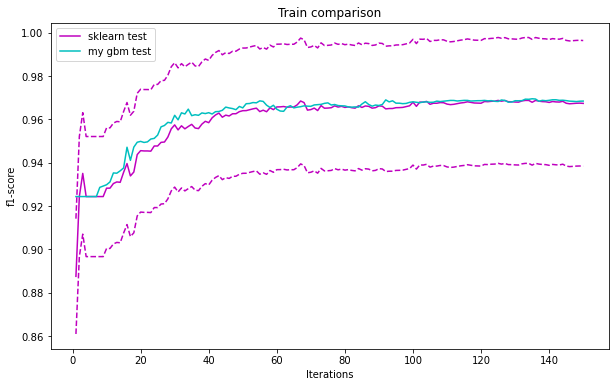

In [49]:
plot_comp_scores(sk_test_scores, my_test_scores, 'Train comparison')